<a href="https://colab.research.google.com/github/fatuunreal/stki3/blob/main/stki3_fatu_rahmat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Libraries
!pip install pyspellchecker
!pip install scattertext
!pip install nltk
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 32.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 32.6 MB/s eta 0:00:00
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9298 sha256=4280eff260695cf43d306f7388b260ece705c378e2bdfb44bedf4a1c505665b5
  Stored in directory: /root/.cache/pip/wheels/bc/be/39/c37ad168eb2ff644c9685f52554440372129450f0b8ed203dd
Successfully built flashtext
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.0 MB/s eta 0:00:00


In [2]:
# Import Data Preprocessing and Wrangling libraries
import re
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from datetime import datetime
import dateutil.parser

# Import NLP Libraries
import nltk
from spellchecker import SpellChecker
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

# Import Visualization Libraries
import plotly.offline as pyo
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import seaborn as sns
import scattertext as st
from IPython.display import IFrame
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import random

# Downloading periphrals
nltk.download('vader_lexicon')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import os

# Assuming the CSV file 'elon-musk-tweets.csv' is in the current working directory
directory = './'  # Use './' for the current directory, or specify the correct path if it's elsewhere

# OR, if your CSV file is named differently or in a subdirectory, adjust the directory and/or filename accordingly:
# directory = 'path/to/your/csv/file'  # Replace with the actual path
# filename = 'your_csv_filename.csv' # Replace with the actual filename

csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]
df_list = []
for csv in csv_files:
    # Construct the full file path by joining the directory and filename
    file_path = os.path.join(directory, csv)
    df = pd.read_csv(file_path)
    df_list.append(df)

In [4]:
# Intializate our tools
sns.set_style('darkgrid')

# For sentiment analysis
sia = SIA()

# To identify misspelled words
spell = SpellChecker()

# To display plotly graphs
pyo.init_notebook_mode()

# Storing csv dataset into a datframe
df = pd.concat(df_list)

In [5]:
df.head()

id  user_name user_location           user_description  \
0  1544379368478212100  Elon Musk           NaN  Mars & Cars, Chips & Dips   
1  1544377493263720450  Elon Musk           NaN  Mars & Cars, Chips & Dips   
2  1544377130590552064  Elon Musk           NaN  Mars & Cars, Chips & Dips   
3  1544375575724400645  Elon Musk           NaN  Mars & Cars, Chips & Dips   
4  1544375148605853699  Elon Musk           NaN  Mars & Cars, Chips & Dips   

                user_created  user_followers  user_friends  user_favourites  \
0  2009-06-02 20:12:29+00:00       101240855           115            13503   
1  2009-06-02 20:12:29+00:00       101240806           115            13503   
2  2009-06-02 20:12:29+00:00       101240806           115            13503   
3  2009-06-02 20:12:29+00:00       101240806           115            13503   
4  2009-06-02 20:12:29+00:00       101240806           115            13503   

   user_verified                       date  \
0           True  2022-07-05 17:55:09+00:00   
1           True  2022-07-05 17:47:42+00:00   
2           True  2022-07-05 17:46:15+00:00   
3           True  2022-07-05 17:40:05+00:00   
4           True  2022-07-05 17:38:23+00:00   

                                                text hashtags  \
0  @BillyM2k I find the gold toe sock – inevitabl...      NaN   
1                 Sock Con, the conference for socks      NaN   
2  Always something new for the magazine cover an...      NaN   
3                   @ExplainThisBob This guy gets it      NaN   
4  Sock tech is so advanced that you can get pret...      NaN   

               source  retweets  favorites  is_retweet  
0  Twitter for iPhone       335       6542       False  
1  Twitter for iPhone      1451      30753       False  
2  Twitter for iPhone      1284      28610       False  
3  Twitter for iPhone       131       3640       False  
4  Twitter for iPhone      1191      23790       False

In [6]:
data = df.copy()
data['original_tweet'] = df['text']
data['datetime'] = data['date']
data['datetime'] = data.datetime.apply(lambda x: dateutil.parser.parse(x))
rt_mask = data.text.apply(lambda x: "RT @" in x)

# standard tweet preprocessing
data.text = data.text.str.lower()
#Remove twitter handlers
data.text = data.text.apply(lambda x:re.sub('@[^\s]+','',x))
#remove hashtags
data.text = data.text.apply(lambda x:re.sub(r'\B#\S+','',x))
# Remove URLS
data.text = data.text.apply(lambda x:re.sub(r"http\S+", "", x))
# Remove all the special characters
data.text = data.text.apply(lambda x:' '.join(re.findall(r'\w+', x)))
#remove all single characters
data.text = data.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
# Substituting multiple spaces with single space
data.text = data.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

# convert the 'date' column to datetime format and remove the timezone information
data['datetime'] = pd.to_datetime(data['datetime']).dt.tz_localize(None)


# Viewing the preprocessed data
data.head()

id  user_name user_location           user_description  \
0  1544379368478212100  Elon Musk           NaN  Mars & Cars, Chips & Dips   
1  1544377493263720450  Elon Musk           NaN  Mars & Cars, Chips & Dips   
2  1544377130590552064  Elon Musk           NaN  Mars & Cars, Chips & Dips   
3  1544375575724400645  Elon Musk           NaN  Mars & Cars, Chips & Dips   
4  1544375148605853699  Elon Musk           NaN  Mars & Cars, Chips & Dips   

                user_created  user_followers  user_friends  user_favourites  \
0  2009-06-02 20:12:29+00:00       101240855           115            13503   
1  2009-06-02 20:12:29+00:00       101240806           115            13503   
2  2009-06-02 20:12:29+00:00       101240806           115            13503   
3  2009-06-02 20:12:29+00:00       101240806           115            13503   
4  2009-06-02 20:12:29+00:00       101240806           115            13503   

   user_verified                       date  \
0           True  2022-07-05 17:55:09+00:00   
1           True  2022-07-05 17:47:42+00:00   
2           True  2022-07-05 17:46:15+00:00   
3           True  2022-07-05 17:40:05+00:00   
4           True  2022-07-05 17:38:23+00:00   

                                                text hashtags  \
0  i find the gold toe sock inevitably off kilter...      NaN   
1                  sock con the conference for socks      NaN   
2  always something new for the magazine cover an...      NaN   
3                                   this guy gets it      NaN   
4  sock tech is so advanced that you can get pret...      NaN   

               source  retweets  favorites  is_retweet  \
0  Twitter for iPhone       335       6542       False   
1  Twitter for iPhone      1451      30753       False   
2  Twitter for iPhone      1284      28610       False   
3  Twitter for iPhone       131       3640       False   
4  Twitter for iPhone      1191      23790       False   

                                      original_tweet            datetime  
0  @BillyM2k I find the gold toe sock – inevitabl... 2022-07-05 17:55:09  
1                 Sock Con, the conference for socks 2022-07-05 17:47:42  
2  Always something new for the magazine cover an... 2022-07-05 17:46:15  
3                   @ExplainThisBob This guy gets it 2022-07-05 17:40:05  
4  Sock tech is so advanced that you can get pret... 2022-07-05 17:38:23

In [7]:
def label_sentiment(x:float):
    if x < -0.05 : return 'negative'
    if x > 0.35 : return 'positive'
    return 'neutral'

# Feature Extraction
data['words'] = data.text.apply(lambda x:re.findall(r'\w+', x ))
data['errors'] = data.words.apply(spell.unknown)
data['errors_count'] = data.errors.apply(len)
data['words_count'] = data.words.apply(len)
data['sentence_length'] = data.text.apply(len)
data['hour'] = data.datetime.apply(lambda x: x.hour)
data['date'] = data.datetime.apply(lambda x: x.date())
data['month'] = data.datetime.apply(lambda x: x.month)
data['year'] = data.datetime.apply(lambda x: x.year)


# Extract Sentiment Values for each tweet
data['sentiment'] = [sia.polarity_scores(x)['compound'] for x in tqdm(data['text'])]
data['overall_sentiment'] = data['sentiment'].apply(label_sentiment);

  0%|          | 0/5904 [00:00<?, ?it/s]

In [42]:
# Get the count of non-null values for each column
column_counts = data.count()

# Create the bar chart
fig = go.Figure(go.Bar(
    x=column_counts.index,
    y=column_counts.values
))

# Add axis labels and title
fig.update_layout(
    xaxis_title="Column",
    yaxis_title="Count",
    title="Number of Rows per Column",
    title_font=dict(size=20),
    font=dict(size=14),
    height=600,
    template='plotly_dark'
)

# Add a subtitle and subheader
fig.add_annotation(
    xref='paper', yref='paper',
    x=0.5, y=1.15,
    text='<b>Data Column Count Distribution</b>',
    showarrow=False,
    font=dict(size=24)
)

fig.add_annotation(
    xref='paper', yref='paper',
    x=0.5, y=1.05,
    text='Number of non-null rows per column in the dataset',
    showarrow=False,
    font=dict(size=16)
)

# Show the chart
fig.show()


In [41]:
# Get the count of missing values for each column
column_na_count = data.isna().sum()

# Create the bar chart
fig = go.Figure(go.Bar(
    x=column_na_count.index,
    y=column_na_count.values,
    marker_color='rgb(253, 128, 93)' # Set custom color for the bars
))

# Add axis labels and title
fig.update_layout(
    xaxis_title="Column",
    yaxis_title="Missing Value Count",
    title="Missing Values per Column",
    font=dict(
        size=14,
        color='white'
    ),
    plot_bgcolor='rgb(17, 17, 17)', # Set dark background color
    paper_bgcolor='rgb(17, 17, 17)', # Set dark background color for the entire plot
)

# Add subheader
fig.add_annotation(
    x=0.5,
    y=1.1,
    xref='paper',
    yref='paper',
    text="<b>Number of missing values per column</b>",
    showarrow=False,
    font=dict(
        size=16,
        color='white'
    )
)

# Show the chart
fig.show()


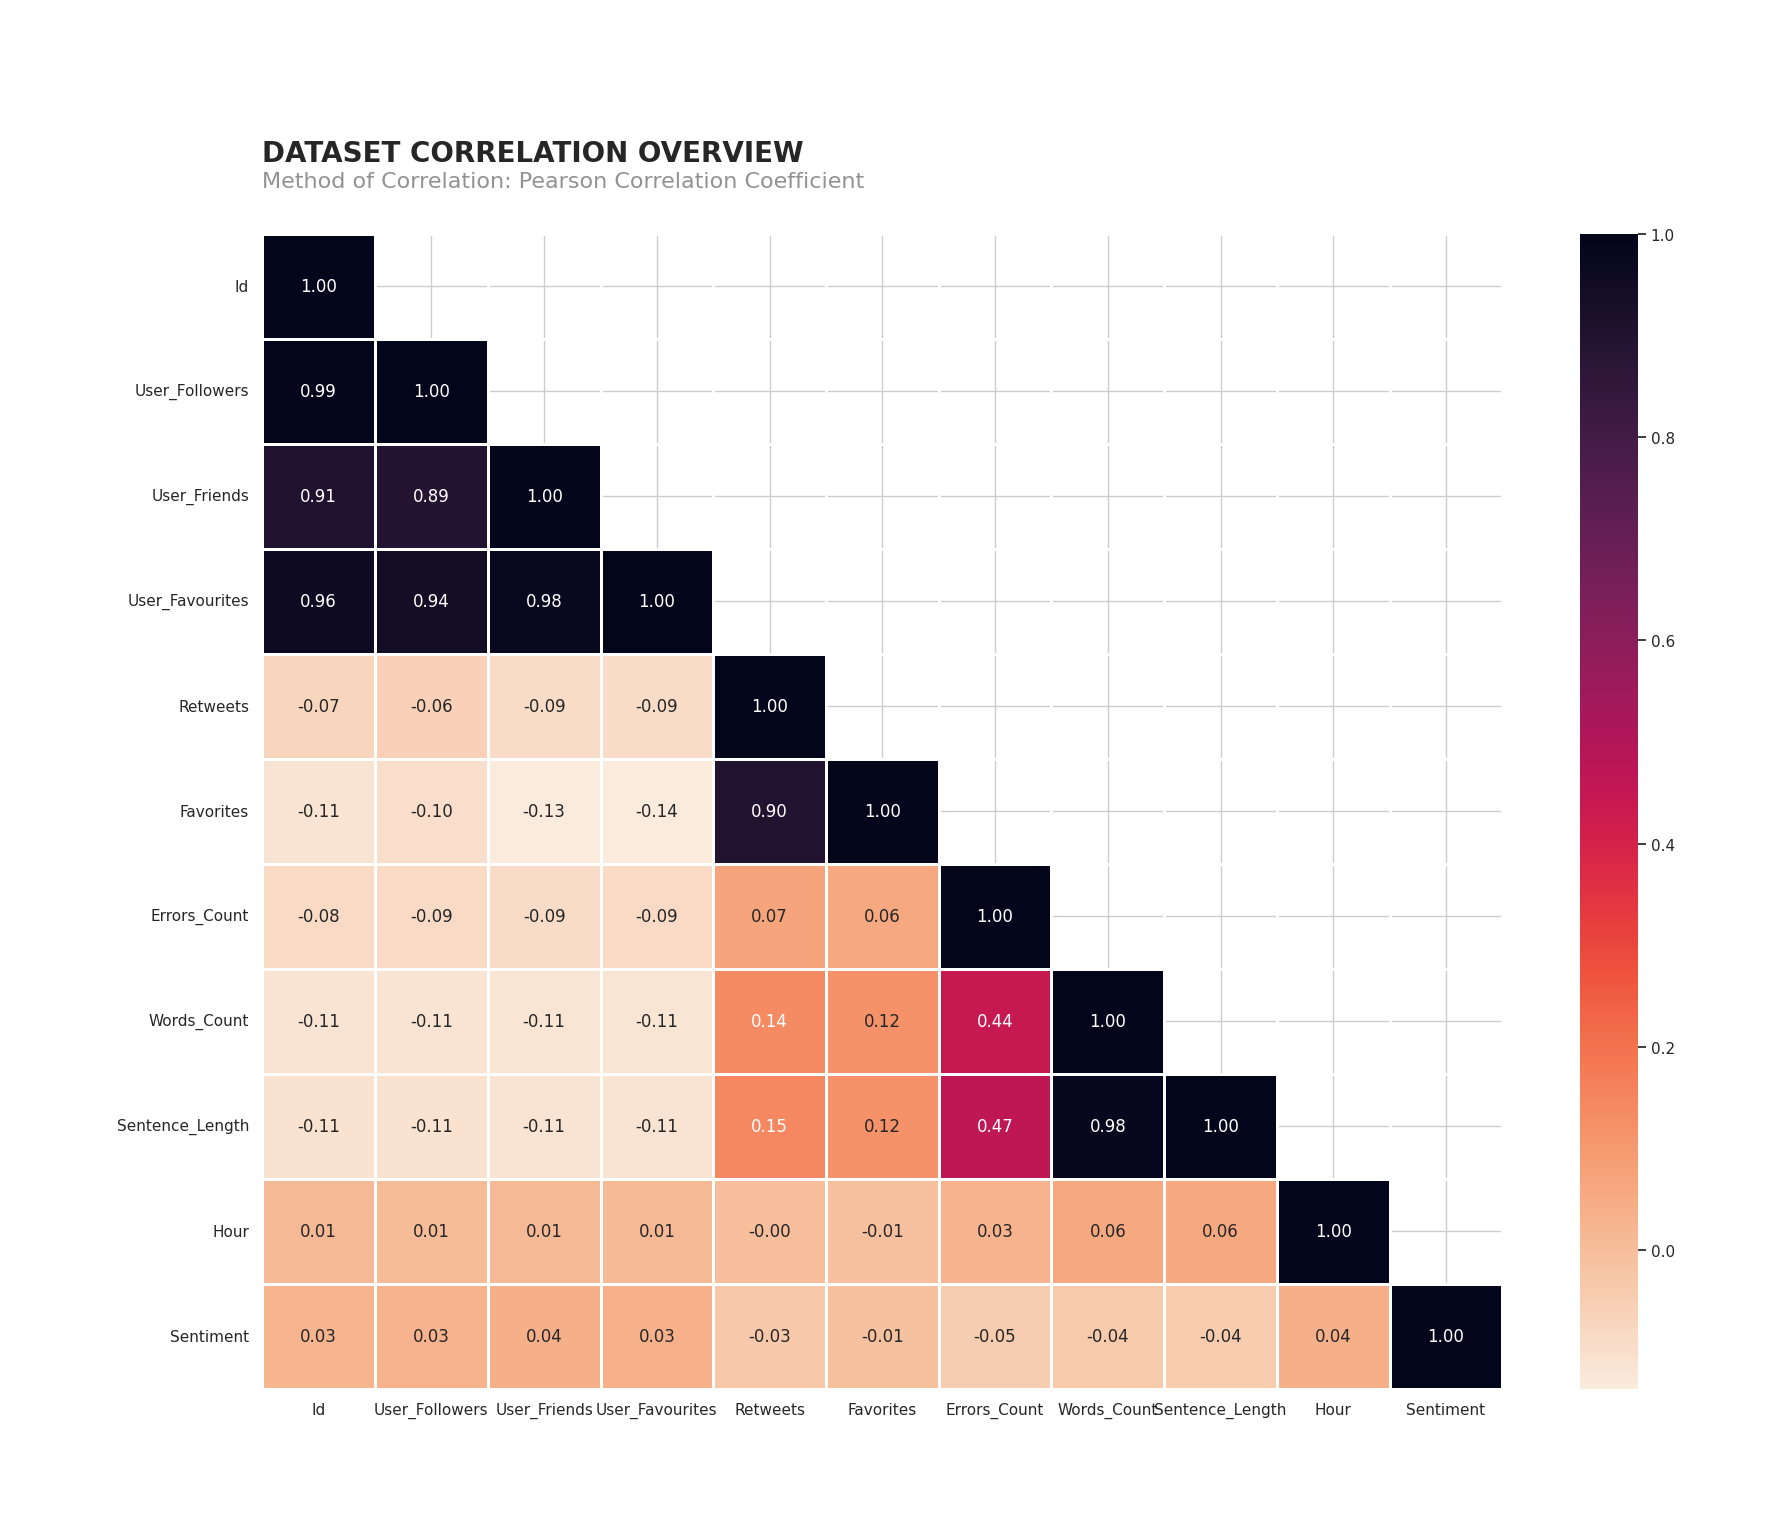

In [11]:
def plot_heatmap(data, cmap=sns.color_palette(palette='rocket_r', as_cmap=True), height=3, linewidth=1, title=' ', subtitle=' '):
    sns.set(style = 'whitegrid', rc = {'figure.figsize': (20,height)})

    mask = np.zeros_like(data, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    mask[np.diag_indices_from(mask)] = False

    g = sns.heatmap(data=data, cmap=cmap,
                    linewidths=linewidth,
                    annot=True,
                    fmt='.2f',
                    mask=mask,
                    cbar_kws=dict(location='right'))

    g.set_xlabel(' \n\n\n\n')
    g.set_ylabel(' \n\n\n\n')

    g.set_xticklabels([tick_label.get_text().title() for tick_label in g.get_xticklabels()])
    g.set_yticklabels([tick_label.get_text().title() for tick_label in g.get_yticklabels()])

    g.set_title(f'\n\n\n\n{title}\n\n'.upper(),
                loc='left',
                fontdict=dict(
                    fontsize=20,
                    fontweight='bold'))

    plt.text(s=f'{subtitle}',
             alpha=0.5,
             x=0,
             y=-0.6,
             horizontalalignment='left',
             verticalalignment='top',
             fontsize=16)

    plt.text(s=' ',
             x=1.2,
             y=1,
             transform=g.transAxes)
    plt.savefig('corr.png')
    return g

# Select only numerical features for correlation analysis
numerical_features = data.select_dtypes(include=np.number).drop(['year', 'month'], axis=1)  # Exclude 'year', 'month'

plot_heatmap(
    height=15,
    data=numerical_features.corr(),  # Calculate correlation on numerical features only
    title='Dataset Correlation Overview',
    subtitle='Method of Correlation: Pearson Correlation Coefficient'
);

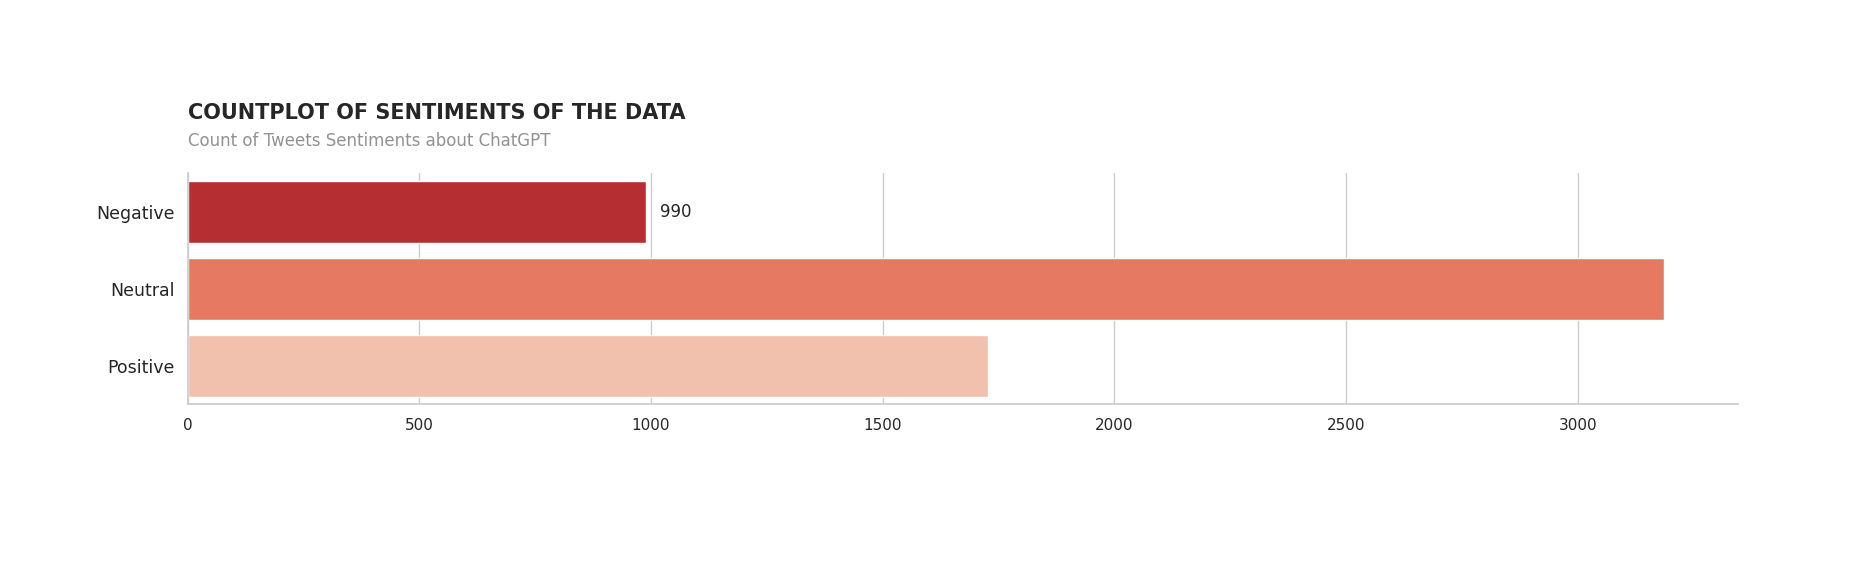

In [12]:
def plot_countplot(data=None, x=None, y=None, palette='Reds_r', height=15, title=' ', subtitle=' ', description=' '):
    sns.set(style = 'whitegrid',
            rc = {'figure.figsize': (20,height)})

    g = sns.countplot(data=data, y=y, x=x, palette=palette)

    g.set_ylabel(' \n\n\n')
    g.set_xlabel(' \n\n\n\n\n')

    g.set_title(
        f'\n\n\n\n{title}\n\n'.upper(),
        loc = 'left',
        fontdict = dict(
            fontsize = 15,
            fontweight = 'bold'))

    g.set_yticklabels(
        [tick_label.get_text().title() for tick_label in g.get_yticklabels()],
        fontdict = dict(
            fontsize = 12.5,
            fontweight = 'medium'))

    plt.text(s = f'{subtitle}',
             alpha = 0.5,
             x = 0,
             y = 1.12,
             horizontalalignment = 'left',
             transform = g.transAxes)

    plt.text(s = f'{description}',
             alpha = 0.5,
             x = 0,
             y = -.18,
             verticalalignment = 'baseline',
             horizontalalignment = 'left',
             transform = g.transAxes)

    g.bar_label(container = g.containers[0], padding = 10,)

    plt.text(s = ' ', x = 1.08, y = 1, transform = g.transAxes)

    sns.despine()
    plt.savefig('countplot.png')
    return g

plot_countplot(y = data['overall_sentiment'],
               title = 'Countplot of Sentiments of the data',
               subtitle='Count of Tweets Sentiments about ChatGPT',
               height = 3);

In [40]:
# create a line plot with Plotly Express
fig = px.line(data, x='datetime', y='retweets', title='Retweets Over Time', template='plotly_dark')

# display the plot
fig.show()

In [29]:
# create a line plot with Plotly Express
fig = px.line(data, x='datetime', y='favorites', title='Favorites Over Time', template='plotly_dark')

# display the plot
fig.show()

In [30]:
# create trace for the line chart
trace = go.Scatter(x=data['datetime'], y=data['user_friends'], mode='lines',
                   name='User Friends', line=dict(color='#3C91E6'))

# set layout options
layout = go.Layout(title='Change in User Friends over Time', template='plotly_dark', xaxis=dict(title='Date'), yaxis=dict(title='Friends'))

# create the figure and display it
fig = go.Figure(data=[trace], layout=layout)
fig.show()


In [31]:
# Create trace
trace = go.Scatter(x=data['datetime'], y=data['user_followers'], mode='lines', marker=dict(color='#00FF00'))

# Create layout
layout = go.Layout(title='Twitter Followers Over Time', xaxis=dict(title='Date'), yaxis=dict(title='Followers'), template='plotly_dark')

# Create figure
fig = go.Figure(data=trace, layout=layout)

# Show figure
fig.show()

In [17]:
# Helper Function to get the running average
def get_weighted(series: pd.Series, beta=0.9):
    weighted = pd.Series(dtype=float)
    weighted[series.index[0]] = 0
    for i in range(1, len(series)):
        current = series.iloc[i]
        previous = weighted.iloc[i-1]
        date = series.index[i]
        weighted[date] = beta*previous + (1-beta)*current
    return weighted

# Get a two-line title for our plots
def get_multi_line_title(title:str, subtitle:str):
    return f"{title}<br><sub>{subtitle}</sub><br>"

In [32]:
def get_multi_line_title(title, subtitle):
    return f"{title}<br><sub>{subtitle}</sub>"

title = get_multi_line_title(
    "Sentence Length of Tweets",
    "Plotting the average number of Sentence Lengths for ceratin hour period of the day"
)

beta = 0.99 #higher value -> smoother curve

length = data.groupby('datetime')['sentence_length'].mean()
length_std = length.std()
length = length[length < 3*length_std]

weighted_length = get_weighted(length, beta)

fig = go.Figure([
    go.Scatter(
        name="Hourly Average Sentence Length",
        x=length.index,
        y=length.values,
        mode="markers",
        opacity=0.3,
        marker_color="salmon"
    ),
    go.Scatter(
        name="Weighted Average Sentence Length",
        x=weighted_length.index,
        y=weighted_length.values,
        opacity=0.8,
        marker_color='crimson'
    ),
])

fig.update_layout(
    hovermode='x',
    title=title,
    xaxis_title="Time",
    yaxis_title="Average Sentence Length per tweet",
    template="plotly_dark",
    legend_orientation = 'h'
)

fig.show()
fig.write_image('sentence_length.png')


In [33]:
title = get_multi_line_title(
    "Word Count of Tweets",
    "Plotting the average number of Word Count for ceratin hour period of the day"
)

beta = 0.99 #higher value -> smoother curve

length = data.groupby('datetime')['words_count'].mean()
length_std = length.std()
length = length[length < 3*length_std]

weighted_length = get_weighted(length, beta)

fig = go.Figure([
    go.Scatter(
        name="Hourly Average Word Count",
        x=length.index,
        y=length.values,
        mode="markers",
        opacity=0.3,
        marker_color="lightseagreen"
    ),
    go.Scatter(
        name="Weighted Average Word Count",
        x=weighted_length.index,
        y=weighted_length.values,
        opacity=0.8,
        marker_color='aquamarine'
    ),
])

fig.update_layout(
    hovermode='x',
    title=title,
    xaxis_title="Time",
    yaxis_title="Average Word Count per tweet",
    template="plotly_dark",
    legend_orientation = 'h'
)

fig.show()

In [34]:
df_copy = data.copy()

title = get_multi_line_title("Sentence Length Distribution", "Distribution of number of characters per tweet, by source")

data = df_copy[df_copy['text'].apply(len) != 0]
top_devices = data.groupby('source')['text'].count().sort_values(ascending=False)[:5].index.tolist()
data = data[data['source'].apply(lambda x: x in top_devices)]

fig = px.histogram(data, x="sentence_length", color="source", opacity=0.75)

fig.update_layout(
    title=title,
    xaxis_title="Number of Characters per Tweet",
    yaxis_title="Count",
    template="plotly_dark",
    legend_title_text="Language",
    font=dict(
        family="Arial",
        size=16,
        color="white"
    ),
    hoverlabel=dict(
        font=dict(
            family="Arial",
            size=16,
            color="white"
        )
    )
)

fig.show()
fig.write_image('sentence_length_dist_by_lang.png')


In [35]:
title = get_multi_line_title(
    "Activity all over the day",
    "Chat GPT tweets across the day")

annual_counts = pd.DataFrame(df_copy['hour'].value_counts()).reset_index()
annual_counts.columns = ['hour', 'count']
annual_counts = annual_counts[annual_counts['hour'] != 2021].sort_values('hour')

fig = go.Figure(go.Bar(
    name="Annual Count",
    x=annual_counts.hour,
    y=annual_counts['count'],
    marker_color=annual_counts['count']
))
# plt.xticks(range(1,25))
fig.update_layout(
    template='plotly_dark',
    title=title,
    xaxis = dict(
        tickvals=np.arange(0,24),
        ticktext=[f"{h:02d}:00" for h in range(24)]
    )
)
fig.show()
fig.write_image('Number of Activity per hour period of the day.png')


In [36]:
title = get_multi_line_title("Time of the day most Tweeted", "")

def format_hour(h: int):
    h = str(h)
    if len(h) == 1:
        h = '0'+h
    h = h+ ":00"
    return h

oc = df_copy
hourly = oc.groupby('hour')['text'].count()
hourly = pd.DataFrame(hourly).reset_index()
hourly.columns =['Hour of Day',"Number of Tweets"]
hourly['Hour of Day'] = hourly['Hour of Day'].apply(format_hour)

fig = px.line_polar(
    data_frame=hourly,
    r = 'Number of Tweets',
    theta='Hour of Day',
    line_close=True,
    color_discrete_sequence=['crimson'],
)

fig.update_layout(
    title=title,
    template="plotly_dark",
    title_x=0.5,
    height=900,
#     width=900
)

fig.write_image('Time of day most tweeted.png')
fig.show()


In [37]:
title = get_multi_line_title(
    'Sentiment Distribution',
    "What are the sentiments of Twitter Users about ChatGPT?"
)

sentiment_pie = pd.DataFrame(df_copy['overall_sentiment'].value_counts() / df_copy.shape[0]*100).reset_index()
sentiment_pie.columns = ['Sentiment', 'Percentage']
fig = px.pie(sentiment_pie, values='Percentage', names='Sentiment', title=title)

fig.update_traces(marker=dict(colors=['#00adb5', '#f8b195', '#f67280']), textposition='inside')
fig.update_layout(
    title=title,
    title_x=0.48,
    template='plotly_dark',
    font=dict(
        family='Arial',
        size=20,  # Increase label font size to 20
        color='white'
    ),
    height=700,
    legend=dict(
        title='',
        orientation='h',
        yanchor='bottom',
        y=-0.15,
        xanchor='center',
        x=0.5,
        font=dict(
            family='Arial',
            size=12,
            color='white'
        )
    )
)
fig.write_image('Sentiment Distribution.png')
fig.show()


In [38]:
sentiment_over_time = df_copy.sort_values('hour')[['hour', 'sentiment', 'overall_sentiment']]
annual_sentiment = pd.DataFrame(sentiment_over_time.groupby('hour')['overall_sentiment'].value_counts())
annual_sentiment.columns = ['Count']
annual_sentiment = annual_sentiment.reset_index()

title = get_multi_line_title('Hourly Tweet Sentiment', "Tweet Sentiments all over the day")
years = annual_sentiment.hour.unique().tolist()
sents = {'positive' : 'mediumseagreen', 'negative': 'crimson', 'neutral': 'royalblue'}

sentiment_bars = []
for s in sents.keys():
    current_year = annual_sentiment[annual_sentiment.overall_sentiment == s]
    sentiment_bars.append(
        go.Bar(name=s, x=current_year.hour, y=current_year.Count, marker_color=sents[s])
    )

fig = go.Figure(sentiment_bars)
fig.update_layout(
    template='plotly_dark',
    title=title,
    xaxis=dict(
        title='Time of Day',
        tickmode='array',
        tickvals=[0, 4, 8, 12, 16, 20, 24],
        ticktext=['12AM', '4AM', '8AM', '12PM', '4PM', '8PM', '12AM'],
        tickangle=0,
        showgrid=False,
        showline=True,
        linewidth=1,
        linecolor='white',
        mirror=True,
        gridcolor='white',
        zeroline=False,
    ),
    yaxis=dict(
        title='Count',
        showgrid=False,
        showline=True,
        linewidth=1,
        linecolor='white',
        mirror=True,
        gridcolor='white',
    ),
    legend=dict(
        title='',
        orientation='h',
        yanchor='bottom',
        y=-0.15,
        xanchor='center',
        x=0.5,
        font=dict(
            family='Arial',
            size=12,
            color='white'
        )
    )
)
fig.write_image('Hourly tweet sentiment.png')
fig.show()


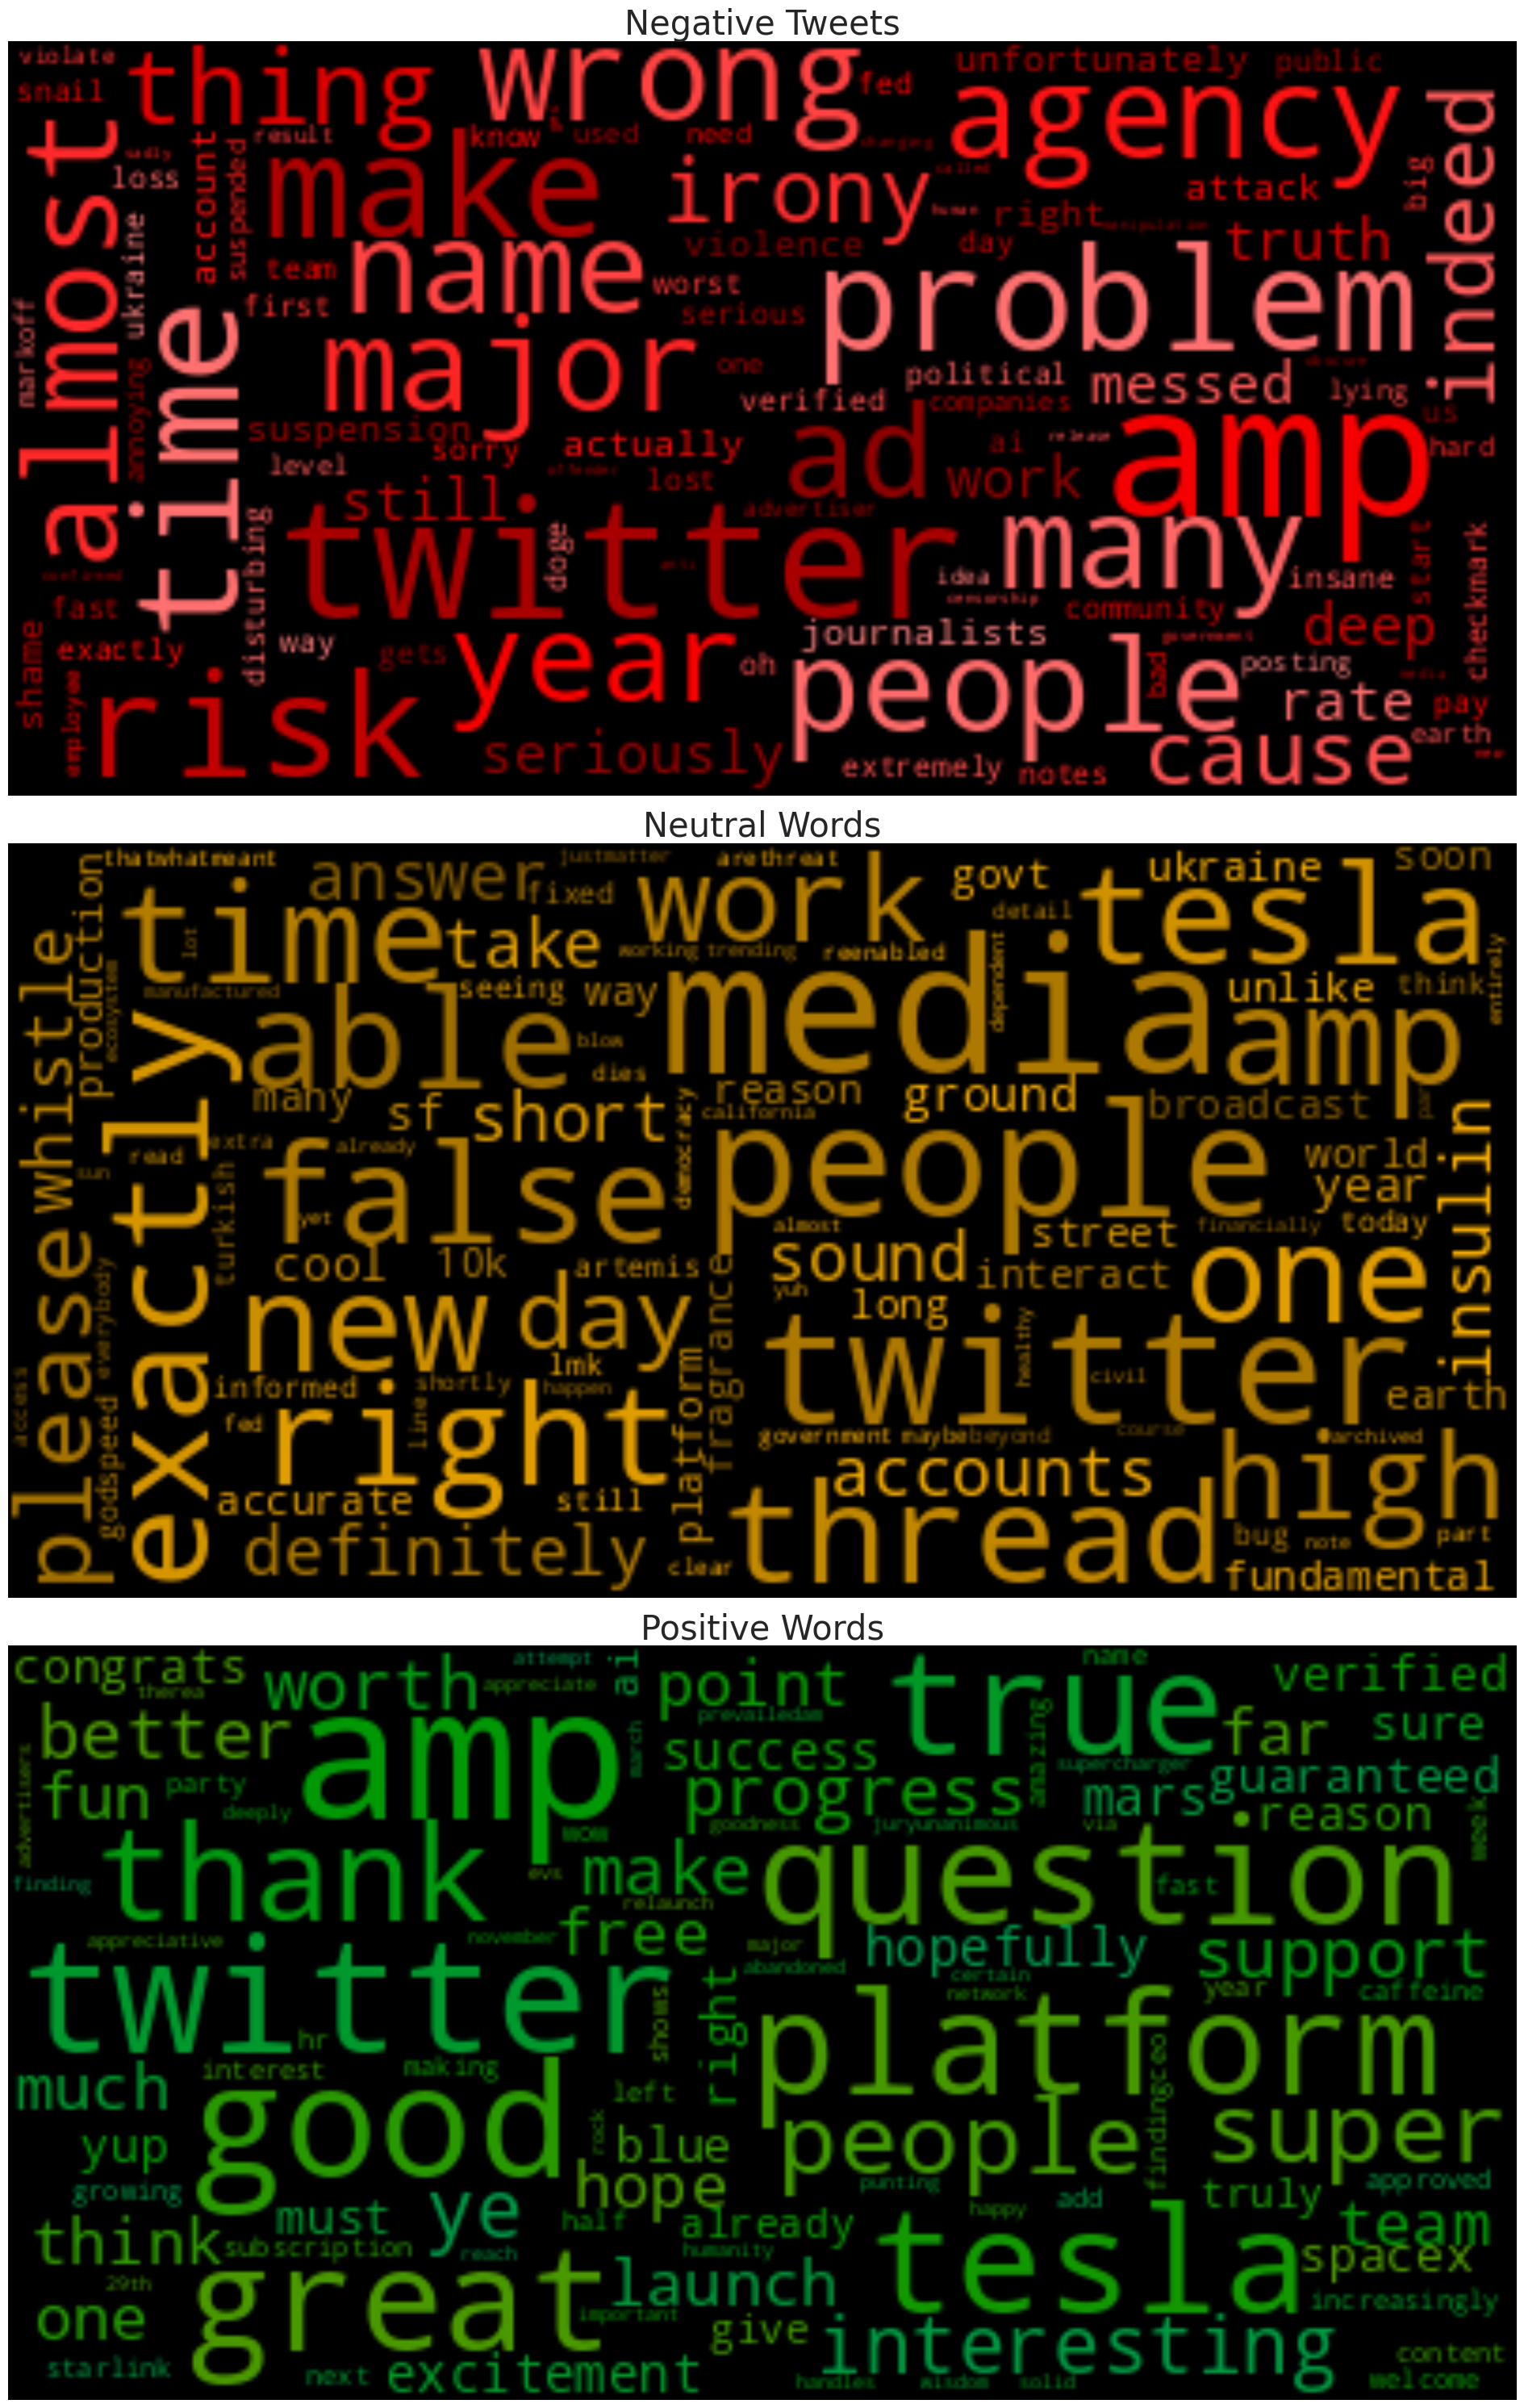

In [39]:
def flatten_list(l):
    return [x for y in l for x in y]

# color coding our wordclouds
def red_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)"

def green_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)"

def yellow_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)"

def generate_word_clouds(neg_doc, neu_doc, pos_doc):
    # Display the generated image:
    fig, axes = plt.subplots(3, 1, figsize=(20,30))
    wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(" ".join(neg_doc))
    axes[0].imshow(wordcloud_neg.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
    axes[0].set_title("Negative Tweets", fontsize=30)
    axes[0].axis("off")

    wordcloud_neu = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(" ".join(neu_doc))
    axes[1].imshow(wordcloud_neu.recolor(color_func=yellow_color_func, random_state=3), interpolation='bilinear')
    axes[1].set_title("Neutral Words", fontsize=30)
    axes[1].axis("off")

    wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(" ".join(pos_doc))
    axes[2].imshow(wordcloud_pos.recolor(color_func=green_color_func, random_state=3), interpolation='bilinear')
    axes[2].set_title("Positive Words", fontsize=30)
    axes[2].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(wspace=1.5)
#     plt.style.use('dark_background')
    plt.show()


sentiment_sorted= data.sort_values('hour', ascending=False)
positive_top_100 = sentiment_sorted[sentiment_sorted['overall_sentiment'] == "positive"].iloc[:100]
negative_top_100 = sentiment_sorted[sentiment_sorted['overall_sentiment'] == "negative"].iloc[:100]
neutral_top_100 = sentiment_sorted[sentiment_sorted['overall_sentiment'] == "neutral"].iloc[:100]

cleanup = lambda x: [y for y in x.split() if y not in stopwords.words('english')]
neg_doc = flatten_list(negative_top_100['text'].apply(cleanup))
pos_doc = flatten_list(positive_top_100['text'].apply(cleanup))
neu_doc = flatten_list(neutral_top_100['text'].apply(cleanup))

generate_word_clouds(neg_doc, neu_doc, pos_doc)
